## **Introduction**


This is a quick study of how Response Surface methods can be implemented to improve the thermal efficiency of a battery bank. In some applications, large temperature differences between batteries in an array can result in overall suboptimal performance. Thermal efficiency is particularly critical in the electronics cooling field, such as in Battery Electric Vehicles and RF systems.

There are many configurations that have become standard because of their simple geometries, such as staggered squared arrays. They also stand on their merits because many have been found to be reltiavely efficient. However, there might exist considerable room for improvement if we implemented systematic ways to sweep through the design space of these arrays. This project is an example of such a
 workflow.

## **The Physics**

I start off in ANSYS Fluent with a simple steady state CFD model of a relatively simple configuration for a battery bank: two concentric circular arrays around one single battery. The design variables I will study are the radial distance of each row to the center battery.

I could have studied many other dimensions of the configuration to allow for a more flexible, and possibly better, design. But I wanted to start off simple and, most importantly, limit myself to only two design variables to visualize the Response Surface. I do intend, however, to extend this project to many dimensions to see if this workflow can produce more exotic shapes.

The boundary conditions are shown below:


*   Velocity inlet: 5 m/s, static temperature of 300 K
*   Static Pressure outlet: 0 Pa (gauge), total temperature of 300 K
*   Fluid domain side walls are no slip and adiabatic
*   Battery walls are no slip as well and dissipate 2786.85 W/m2 each.

I debated which turbulance model to assume, and initially thought of going with $k-\omega$ $SST$ since it's better suited for flow over external bodies where large adverse pressure gradients are present, such as airfoils and flow over cylinders. But some references [1,2] instead used $k-\epsilon$ $RNG$, and I decided to follow that approach to be able to compare my model with their results.

The nominal design has the outer row of batteries at 4 inches radial distance from the center, while the inner row of batteries is at 2 inches radial distance from the center with an angular offset of 22.5 degrees. For the nominal case, the maximum temperature difference accross the bank is 4.8 K. 

To validate the solution, I did a simple convection hand calculation assuming Hilbert's HTC correlation for flow over a cylinder, and did another hand calculation for the advection rise. Both were reasonably close considering that 2D effects are not accounted for in hand-calcs.
The velocity and temperature flow fields are shown below.

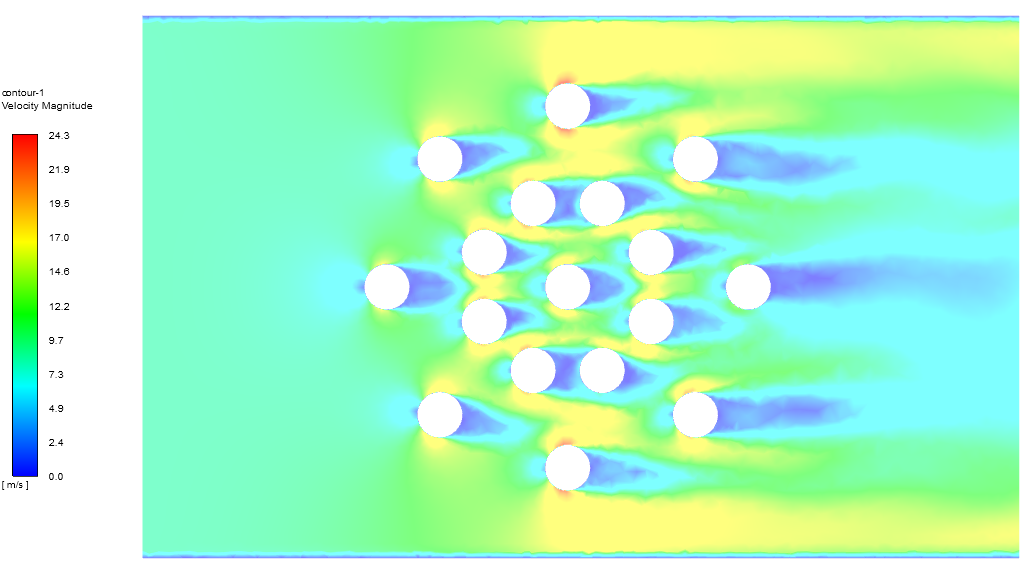

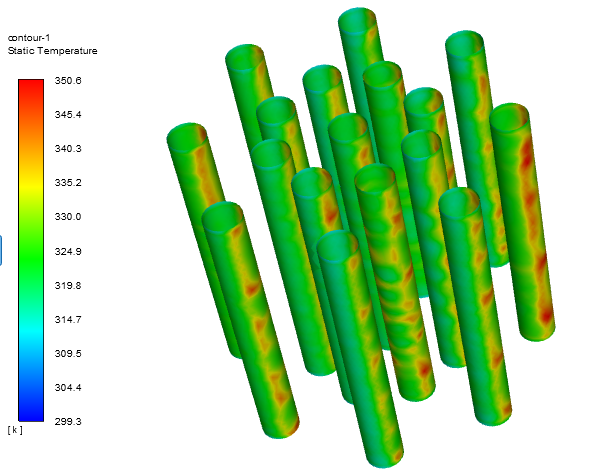



## **The Data**

The dataset available for this optimization task was produced by running a Latin Hypercube Design experiment in ANSYS Workbench. Basically, the Fluent CFD model discussed in The Physics section was run 200 times, each with a varying distance from the center for each circular array of batteries.


The response variables recorded were the average temperature at each battery wall. For this problem, we could certainly get away with computing the max temperature difference accross the entire battery bank in the physics simulation step and record only that, but I decided to output the temperature for each battery instead in case I'm interested in creating other types of response variables.



In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# Upload data
data = pd.read_csv('doe_results.csv',skiprows=6)
data.head()

,Name,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22
0,DP 0,2.0000,4.0000,0.050800,0.101600,2786.85,327.58881,326.18289,329.53858,326.89293,...,325.92104,325.38381,326.01391,328.13513,327.08495,325.42036,326.00955,325.10609,325.60959,326.25773
1,DP 1,2.1261,3.4785,0.054003,0.088354,2786.85,327.70990,326.38259,329.48143,327.04577,...,325.74098,326.65075,325.77048,327.16704,326.98736,326.37343,326.07585,324.94672,325.61956,326.14694
2,DP 2,2.2055,4.6568,0.056020,0.118283,2786.85,327.55007,326.68401,329.07558,326.86733,...,325.86191,325.41117,325.97510,327.98622,327.08667,325.35904,326.02351,324.88785,325.55720,326.13557
3,DP 3,1.6744,4.6916,0.042530,0.119167,2786.85,329.26091,323.48560,329.38587,323.90283,...,326.06915,324.95748,326.25851,332.11813,324.23322,324.88542,324.17970,324.78022,323.97623,326.10304
4,DP 4,2.2837,4.6096,0.058006,0.117084,2786.85,327.60756,326.35367,329.27097,326.95316,...,325.87847,325.33014,325.99958,327.73931,327.13953,325.48248,326.00327,324.89345,325.68632,326.09495


To run the trades, ANSYS labels each paremeter as P1, P2... etc. In this case, P1 is the inner bank distance from the center, and P2 is the distance from the center for the outer bank.

Parameters P6 through P22 correspond to the average temperature in each battery wall. With this in mind, I'll go ahead and separate the data into input and output datasets.

In [3]:
# Inputs
datain = data.iloc[:,1:3]
datain.head()

,P1,P2
0,2.0000,4.0000
1,2.1261,3.4785
2,2.2055,4.6568
3,1.6744,4.6916
4,2.2837,4.6096


In [4]:
# Outputs
dataou = data.iloc[:,6:]
dataou.head()

,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22
0,327.58881,326.18289,329.53858,326.89293,327.34948,328.33070,325.05755,325.92104,325.38381,326.01391,328.13513,327.08495,325.42036,326.00955,325.10609,325.60959,326.25773
1,327.70990,326.38259,329.48143,327.04577,327.26161,328.31323,324.99223,325.74098,326.65075,325.77048,327.16704,326.98736,326.37343,326.07585,324.94672,325.61956,326.14694
2,327.55007,326.68401,329.07558,326.86733,327.38224,328.55948,324.89364,325.86191,325.41117,325.97510,327.98622,327.08667,325.35904,326.02351,324.88785,325.55720,326.13557
3,329.26091,323.48560,329.38587,323.90283,327.23922,323.96522,324.81179,326.06915,324.95748,326.25851,332.11813,324.23322,324.88542,324.17970,324.78022,323.97623,326.10304
4,327.60756,326.35367,329.27097,326.95316,327.39873,329.41044,324.88224,325.87847,325.33014,325.99958,327.73931,327.13953,325.48248,326.00327,324.89345,325.68632,326.09495


Now I need to compute the maximum temperature difference accross all the batteries for each case. This will be the response variable.

In [5]:
# Compute Response Variable
rows,cols = np.shape(dataou)
maxTempDiff = np.ones(shape=(rows,1))
for i in np.arange(0,rows):
  tempDiff = abs(np.multiply(dataou.iloc[i,:].values,np.ones(shape=(cols,cols))) -np.transpose(np.multiply(dataou.iloc[i,:].values,np.ones(shape=(cols,cols)))))
  maxTempDiff[i,0] = np.max(tempDiff)

maxTempDiff = pd.DataFrame(maxTempDiff)
maxTempDiff.head()

,0
0,4.48103
1,4.53471
2,4.18773
3,8.63253
4,4.52820


Now let's split the data between training and testing data sets. I'm assuming a 70-30 split.

In [6]:
datain_tr,datain_te,dataou_tr,dataou_te,maxTempDiff_tr,maxTempDiff_te = train_test_split(datain,dataou,maxTempDiff,test_size=0.3,random_state=42)

The last step to prep the data is scaling. We can't have negative values in teh input data since it doesn't make sense to have a negative distance from the center. We also don't have negative output values since the temperature difference between each battery is an absolute value. So I'll scale everything linearly between 0 and 1.

In [7]:
# Create Scalers
scalerin = MinMaxScaler(feature_range=(0,1))
scalerou = MinMaxScaler(feature_range=(0,1))
scalerTempDiff = MinMaxScaler(feature_range=(0,1))

# Fit the scalers to the data
scalerin.fit(datain)
scalerou.fit(dataou)
scalerTempDiff.fit(maxTempDiff)

# Scale the datasets
datain_tr_sc = scalerin.transform(datain_tr)
datain_te_sc = scalerin.transform(datain_te)
dataou_tr_sc = scalerou.transform(dataou_tr)
dataou_te_sc = scalerou.transform(dataou_te)
maxTempDiff_tr_sc = scalerTempDiff.transform(maxTempDiff_tr)
maxTempDiff_te_sc = scalerTempDiff.transform(maxTempDiff_te)

## **The Model**

If we take a quick look at how the response variable behaves with repsect to the inputs, it is clear that the relationship is non-linear, with the temperature difference decreasing rapidly with increasing inner bank distance, and suddenly flatteting out.

This latter point is important for a few reasons:
1. It turns out that the nominal design, with inner and outer distances at 2 and 4 inches repsetively, is in the flat part of the data set, which means that it's pretty efficient already.
2. The fact that the data set is pretty flat in some regions might cause problems with Gradient Descent optimizers.

Because the nominal design is on the flat part of the data set the improvement that the optimizer will provide most likely will be marginal.

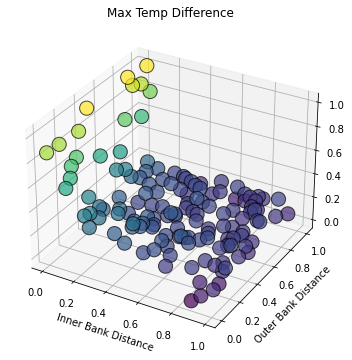

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(datain_tr_sc[:,0], datain_tr_sc[:,1], maxTempDiff_tr_sc,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=maxTempDiff_tr_sc)
plt.xlabel('Inner Bank Distance'); plt.ylabel('Outer Bank Distance'); plt.title('Max Temp Difference');
plt.show()

With this in mind, we can try a few models. Let's try simple linear regression.

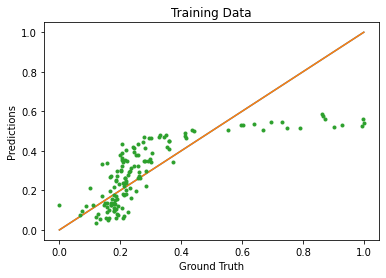

In [9]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression().fit(datain_tr_sc,maxTempDiff_tr_sc)
maxTempDiffes_tr_sc = model_lr.predict(datain_tr_sc)
plt.plot([[0,0],[1,1]]);
plt.plot(maxTempDiff_tr_sc,maxTempDiffes_tr_sc,'.');
plt.xlabel('Ground Truth'); plt.ylabel('Predictions'); plt.title('Training Data');

Not great. Let's try with non-linear features, such as the squared, $X^2$, and cross-terms, $X_1X_2$, in a second order polynomial.

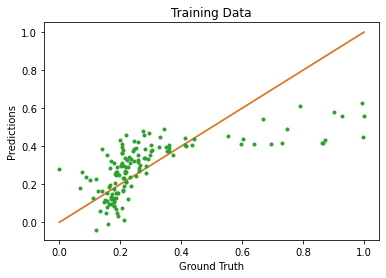

In [10]:
model_lr = LinearRegression().fit(np.concatenate((np.expand_dims(np.multiply(datain_tr_sc[:,0],datain_tr_sc[:,1]),1),datain_tr_sc**2),axis=1),maxTempDiff_tr_sc)
maxTempDiffes_tr_sc = model_lr.predict(np.concatenate((np.expand_dims(np.multiply(datain_tr_sc[:,0],datain_tr_sc[:,1]),1),datain_tr_sc**2),axis=1))
plt.plot([[0,0],[1,1]]);
plt.plot(maxTempDiff_tr_sc,maxTempDiffes_tr_sc,'.');
plt.xlabel('Ground Truth'); plt.ylabel('Predictions'); plt.title('Training Data');

Pretty much zero improvement. As mentioned earlier, this dataset is heavily non-linear, so we shouldn't expect much improvement by increasing the order of the polynomial fit. Let's try using Support Vector Regression (SVR).

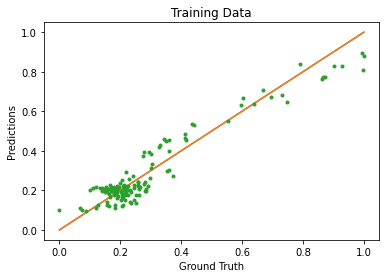

In [11]:
from sklearn.svm import SVR as svr
model_svr = svr()
model_svr.fit(datain_tr_sc,maxTempDiff_tr_sc[:,0])
maxTempDiffes_tr_sc = model_svr.predict(datain_tr_sc)
plt.plot([[0,0],[1,1]]);
plt.plot(maxTempDiff_tr_sc,maxTempDiffes_tr_sc,'.');
plt.xlabel('Ground Truth'); plt.ylabel('Predictions'); plt.title('Training Data');

Much better. Let's see what the test predictions look like.

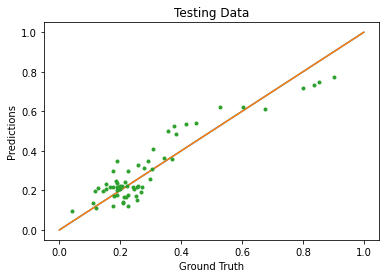

In [12]:
maxTempDiffes_te_sc = model_svr.predict(datain_te_sc)
plt.plot([[0,0],[1,1]]);
plt.plot(maxTempDiff_te_sc,maxTempDiffes_te_sc,'.');
plt.xlabel('Ground Truth'); plt.ylabel('Predictions'); plt.title('Testing Data');

They're considerably better than the Linear Regression models, but we can still observe that the residuals are non-linear. Let's try Gaussian Process Regression (GPR).

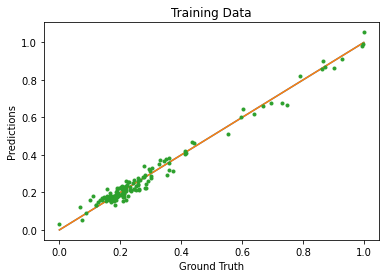

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
model_gpr = gpr()
model_gpr.fit(datain_tr_sc,maxTempDiff_tr_sc)
maxTempDiffes_tr_sc = model_gpr.predict(datain_tr_sc)
plt.plot([[0,0],[1,1]]);
plt.plot(maxTempDiff_tr_sc,maxTempDiffes_tr_sc,'.');
plt.xlabel('Ground Truth'); plt.ylabel('Predictions'); plt.title('Training Data');

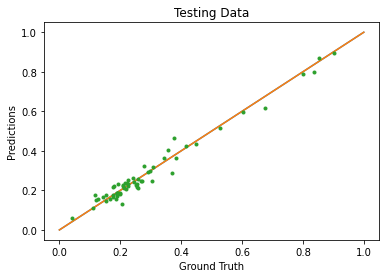

In [14]:
maxTempDiffes_te_sc = model_gpr.predict(datain_te_sc)
plt.plot([[0,0],[1,1]]);
plt.plot(maxTempDiff_te_sc,maxTempDiffes_te_sc,'.');
plt.xlabel('Ground Truth'); plt.ylabel('Predictions'); plt.title('Testing Data');

There is a much stronger correlation in the testing dataset when using GPR in contrast to SVR. This isn't too surprising since GPR is a pretty robust non-parametric form of regression. However, it comes at the expense of training time. From all the methods, GPR takes much longer but for a dataset as small as ours, the impact is negligible.

## **The Optimizer**

Finally, in this section we run the GPR Response Surface model we generated in the previous section through a numerical optimization method to help us find which configuration produces the lowest temperature variation accross all the batteries.

Let's try first using a deterministic Gradient Descent method and create an objective function, which simply will be a wrapper for the prediction call in the GPR model.

In [15]:
from scipy.optimize import minimize

def obj(x):
  x = np.expand_dims(x,0)
  return model_gpr.predict(x).flatten()

# Test the objective function call
obj(np.array([0.5, 0.5]))

array([0.22269201])

In [16]:
# Run the optimization
#x0 = scalerin.transform(np.expand_dims(datain.iloc[0,:],1));
x0 = np.array([1, 1])   # First guess
bnds = ((0, 1), (0, 1))
options = {'disp':True}
res = minimize(obj,x0,bounds=bnds,method='L-BFGS-B',tol=1e-6)
x_final = scalerin.inverse_transform(np.expand_dims(res.x,0))
j_final = scalerTempDiff.inverse_transform(np.expand_dims(res.fun,0))
x_final

array([[2.3485, 4.695 ]])

In [17]:
j_final

array([[3.94242729]])

 We can observe that the solution of the GD optimizer is highly sensitive to the initial condition. Furthermore, it's highly sensitive to the method applied. This is happening for two reasons:

 1. The response surface has a few local minima. The GD algorithm can fall into any one of these depending on where it starts the search.
 2. The response surface decays rapidly and then flattens out considerably, as previously mentioned. Some descent methods can diverge if the surface is too flat, which is the case here after the 2 in mark for the inner bank distance.

To address these short-comings, a global minimzation algortihm would work better. Let's try with the Genetic Algorithm. I'm using the code developed by Ryan Solgi [3]. Solgi's code is pretty robust. I repeated this same workflow in MATLAB [4] and used it's Genetic Algorithm routine which produced pretty similar results.

In [18]:
!pip install geneticalgorithm

Now let's call the GA

 The best solution found:                                                                           
 [0.8895083  0.00941589]

 Objective function:
 0.02594161033630371


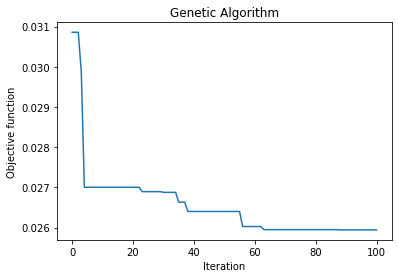

In [19]:
from geneticalgorithm import geneticalgorithm as ga
varbound=np.array([[0,1]]*2)
model=ga(function=obj,dimension=2,variable_type='real',variable_boundaries=varbound)
model.run()

In [20]:
x_final = scalerin.inverse_transform([[0.89354153, 0.01411718]])
j_final = scalerTempDiff.inverse_transform([[0.026091068983078003]])
x_final

array([[2.27431974, 3.323637  ]])

Now we have a much better solution. We can validate that this solution is better than the one provided by the Gradient Descent methods because we have readily available data that can show us what is the best design, and we have a Response Surface that can be visualized since we have only two design variables. 

## **Validation**

The optimizer's solution is as good as a prediction. To confirm that it is in fact a better design we need to take it's design variables and input them into the CFD model and run it.

Below are the velocity and temperature fields for the optimized design per the GA's solution.

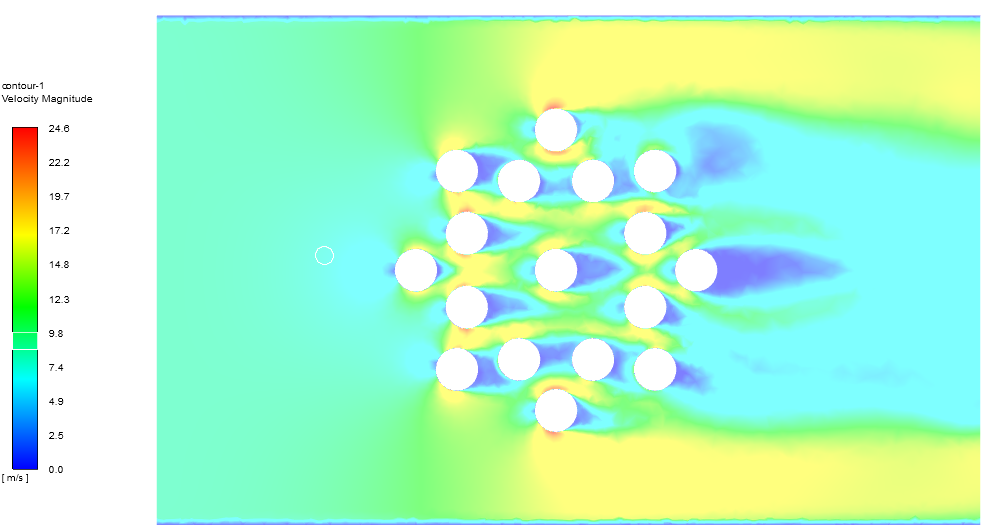

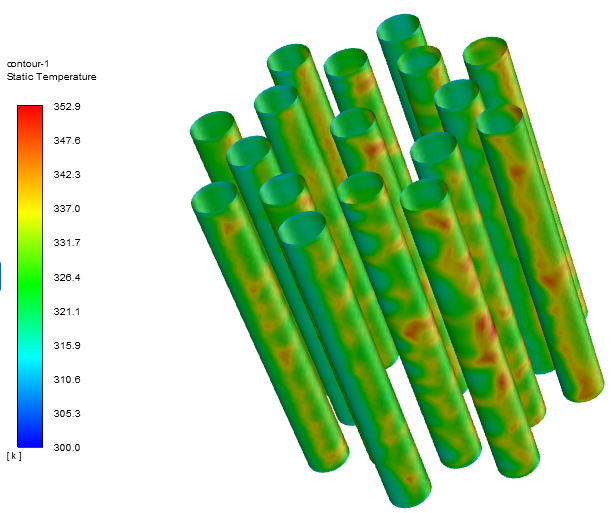

The maximum temperature difference accross all the batteries in this design is 3.63 K, which is just a over a 1 K improvement from our nominal design which was at 4.8 K.

Per the discussion on the rapidly decaying shape of the Response Surface, we expected only a marginal improvement. It should be noted, however, that what ultimately defines if an improvement is marginal or not is how sensitive the application is to temperatures differences. It very well could be the case that a 1 K improvement makes all the difference.

It should also be noted that the improvement is marginal in contrast to the nominal design, but not so when compared to designs located in the steep part of the surface, such as an inner bank at 1.6 inches from the center and the outer at 4.7 inches, which would produce a temperature difference as large as 9.5 K.

## **Conclusion**

Response Surface Optimization (RSO) is capable of making considerable improvements to standard designs by systematically sweeping through the design space in an automated way, but it has some limitations. 

The first glaring limitation is the availability of the data. Running a DOE of any kind represents computational overhead and time. That can be managed with simplified models and running DOEs overnight, but that has its limitations as well.

The second is that contrary to directly optimizing the model, the Response Surface is an approximation of the results, so the optimal solution will likely be better, but not optimal.

The third is that the optimized design is sensitive to the Regression Model selected and built. As we saw, Linear Regression was terrible at representing the model, but we could have just as well worked on improving SVR by using other Kernel functions.

Lastly, the optimized design is highly sensitive to the optimization routine selected and (if using Gradient Descent methods) on the initial guess fed to the routine. Evolutionary methods, such as Genetic Algorithms, are much better at searching the Response Surface and finding global optima. But some Evolutionary methods are stochastic and might produce different results each time run if a random seed is not fixed.

Despite these limitations, it still is highly useful when exploring more complicated design spaces with many (definitely more than 2) design variables that generate a high dimensional Response Surface. Furthermore, in our problem we could have easily picked out the best case from the data set, but that approach doesn't work if we have constraints. RSO is very well suited for that latter scenario because contraint functions can be included in the formulation of the problem or can be added as penatly terms in the objective function.

## **References**

1. N. E. Gharbi, A. Kheiri, M. E. Ganaoui, and R. Blanchard, ‘Numerical optimization of heat exchangers with circular and non-circular shapes’, Case Studies in Thermal Engineering, vol. 6, pp. 194–203, 9 2015.
2. A. M. N. Elmekawy, A. A. Ibrahim, A. M. Shahin, S. Al-Ali, and G. E. Hassan, ‘Performance enhancement for tube bank staggered configuration heat exchanger – CFD Study’, Chemical Engineering and Processing - Process Intensification, vol. 164, 7 2021.
3. Solgi, Genetic Algorithm: https://github.com/rmsolgi/geneticalgorithm
4. Lebron, RSO Implementation in MATLAB: https://github.com/julionlf/Battery_Bank_Optimization